# Golgi-Granule Layer Delay Network

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../model")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import nengo
import nengo_gui.jupyter
import nengo_bio as bio

from granule_golgi_circuit import GranuleGolgiCircuit

## Test Network

In this test I'm instantiating the delay network and feed a 2 Hz "rectified" (discrete values $-1$ and $1$) sine wave into it. I then try to learn a delayed version of the sine wave with double the frequency off the internal representation.

In [158]:
def build_test_network(*args, **kwargs):
    with nengo.Network() as model:
        # Build the actual network

        # Pre-cerebellum ensemble (Input)
        ens_pc = bio.Ensemble(
            n_neurons=100,
            dimensions=1,
            p_exc=1.0,
            label="ens_pc",
        )

        # The actual network
        net_granule_golgi = GranuleGolgiCircuit(
            ens_pc, *args, **kwargs)

        # Generate a 2Hz sine wave
        freq = 2.0
        nd_stim = nengo.Node(
            lambda t: np.sign(np.sin(freq * 2.0 * np.pi * t)),
            label="nd_stim")
        nengo.Connection(nd_stim, ens_pc)

        # Try to learn a shifted sine wave with twice the frequence off the granule cell layer
        nd_stim_tar = nengo.Node(
            lambda t: np.sin(2.0 * freq * 2.0 * np.pi * (t - net_granule_golgi.theta * 0.5)),
            label="nd_stim_tar")
        nd_tar = nengo.Node(
            size_in=1,
            label="nd_tar")
        c = nengo.Connection(
            net_granule_golgi.ens_granule.neurons,
            nd_tar,
            transform=np.zeros((nd_tar.size_in,
                net_granule_golgi.n_granule)),
            learning_rule_type=nengo.PES(
                learning_rate=1e-3))
        nd_err = nengo.Node(
            size_in=1,
            label="nd_err")
        nengo.Connection(nd_tar, nd_err, transform=1)
        nengo.Connection(nd_stim_tar, nd_err, transform=-1)
        nengo.Connection(nd_err, c.learning_rule)

        # Probe the error signal as well as the granule cell layer
        probe_granule = nengo.Probe(
            net_granule_golgi.ens_granule,
            synapse=100e-3,
            sample_every=1e-3)
        probe_err = nengo.Probe(
            nd_err,
            synapse=100e-3,
            sample_every=10e-3,)

    return model, probe_granule, probe_err

In [149]:
n_repeat = 40

def analyse_delay_representation(seed=34981, *args, **kwargs):
    """
    Creates a test network with the given arguments, runs it for
    20 * θ and returns the time- and frequency domain
    representations of the Delay Network representation.
    """
    np.random.seed(seed)
    model, probe_granule, _ = build_test_network(*args, **kwargs)
    net_granule_golgi = model.networks[0]
    theta = net_granule_golgi.theta
    T = theta * n_repeat
    with nengo.Simulator(model, progress_bar=None) as sim:
        sim.run(T)
        
        ts = sim.trange(probe_granule.sample_every)
        ys = sim.data[probe_granule]

        it0 = np.min(np.where(ts > theta))

        ts = ts[it0:]
        ys = ys[it0:]

        Ys = np.fft.fftshift(np.fft.fft(ys - np.mean(ys, axis=0), axis=0))
        freqs = np.fft.fftshift(np.fft.fftfreq(len(ys), probe_granule.sample_every))
        
        return ts, ys, Ys, freqs

def plot_delay_representation(ts, ys, Ys, freqs):
    """
    Plots the Delay Network Representation in the time domain,
    as well as the phases of the maximum frequency for each
    dimension.
    """
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))

    Ys = Ys[:, :min(6, Ys.shape[1])] # Plot at most 6 state dimensions
    ys = ys[:, :min(6, ys.shape[1])]
    
    i0 = Ys.shape[0] // 2 + 1
    Ys = Ys[i0:]
    freqs = freqs[i0:]

    T0, T1 = np.min(ts), np.max(ts) 
    theta = (T1 - T0) / (n_repeat - 1)
    axs[0].plot(ts, ys)
    axs[0].set_xlabel('Time $t$ (s)')
    axs[0].set_title('State')
    axs[0].set_xlim(0.5 * (T1 - T0 - theta) + T0, 0.5 * (T1 - T0 + theta) + T0)

    cmap = matplotlib.cm.get_cmap('tab10')
    hts = np.linspace(-0.5, 0.5, int(0.0075 * len(ts)))
    h = np.exp(-np.square(hts) / np.square(0.1))
    h /= np.sum(h)

    Ys_flt = np.apply_along_axis(
        lambda x: np.convolve(np.real(10.0 * np.log10(np.abs(x))), h / 10, 'same'),
        axis=0, arr=Ys)
    Ys_cpy = np.copy(Ys)
    Y_peaks = [[] for _ in range(Ys.shape[1])]
    n_phases = 1
    for j in range(n_phases):
        max_freq_i = np.argmax(np.abs(Ys_cpy), axis=0)
        max_freq = -freqs[max_freq_i]
        for i, idc in enumerate(max_freq_i):
            Y = Ys[idc, i]
            angle = np.arctan2(np.real(Y), np.imag(Y))
            color = cmap(i / 10)
            axs[1].quiver(np.cos(angle + np.pi), np.sin(angle + np.pi),
                          2.0 * np.cos(angle), 2.0 * np.sin(angle),
                          scale=1., angles='xy', scale_units="xy",
                          alpha=np.linspace(1.0, 0.5, n_phases)[j],
                          color=color, width=0.0125,
                          zorder=-10*j)

            # Remember this peak
            Y_peaks[i].append((Ys[idc, i], freqs[idc], Y, idc))

            # Mask out all coeffs surrounding the current peak
            Y_max = Ys_flt[idc, i]
            for k in range(idc, Ys.shape[0]):
                if Y_max >= Ys_flt[k, i]:
                    Y_max = Ys_flt[k, i]
                    Ys_cpy[k, i] = 0
                else:
                    break
            Y_max = Ys_flt[idc, i]
            for k in range(idc, -1, -1):
                if Y_max >= Ys_flt[k, i]:
                    Y_max = Ys_flt[k, i]
                    Ys_cpy[k, i] = 0
                else:
                    break

    θs = np.linspace(-np.pi, np.pi, 100)
    axs[1].plot(np.cos(θs), np.sin(θs), 'k--', linewidth=0.75)
    axs[1].set_xlim(-1, 1)
    axs[1].set_ylim(-1, 1)
    axs[1].set_aspect('equal')
    axs[1].set_title('Phases')

    axs[2].plot(freqs, 10.0 * np.log10(np.abs(Ys)))
    for i, peaks in enumerate(Y_peaks):
        color = cmap(i / 10)
        for a, f, _, _ in peaks:
            axs[2].plot(f, 10.0 * np.log10(a), '^', color=color)
    axs[2].set_title('Frequencies')
    axs[2].set_xlabel('Freq')
    axs[2].set_ylabel('Power (dB)')
    axs[2].set_xlim(0, 20)
    axs[2].set_ylim(-10, None)

    fig.tight_layout()

    return fig, axs

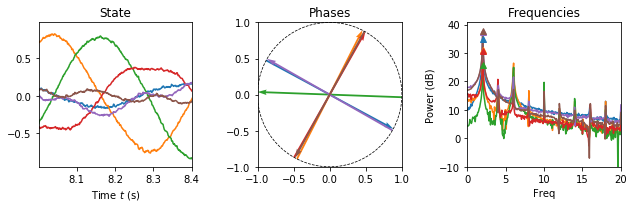

In [113]:
plot_delay_representation(*analyse_delay_representation(
        mode="direct",));

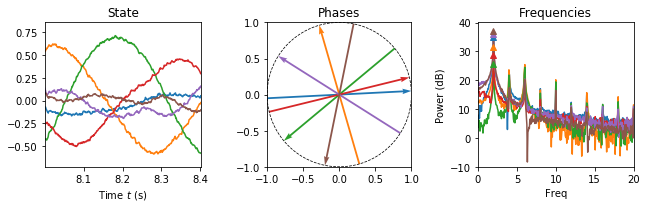

In [114]:
plot_delay_representation(*analyse_delay_representation(
        mode="single_population",));

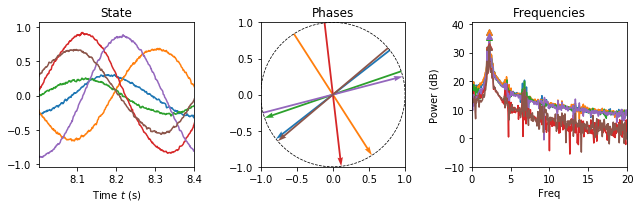

In [115]:
plot_delay_representation(*analyse_delay_representation(
        q=6,
        mode="echo_state",));

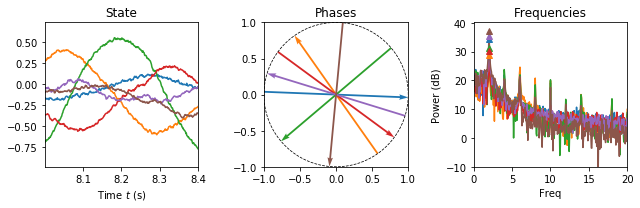

In [116]:
plot_delay_representation(*analyse_delay_representation(
        mode="two_populations",));

Solved 199/200 neuron weights

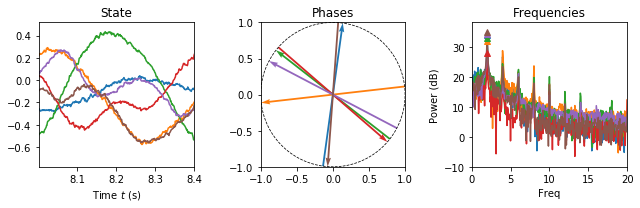

In [117]:
plot_delay_representation(*analyse_delay_representation(
                            mode="two_populations_dales_principle",
                            solver_relax=False));

In [171]:
def analyse_prediction_learnability(T=50.0, seed=34981, *args, **kwargs):
    np.random.seed(seed)
    model, _, probe_err = build_test_network(*args, **kwargs)
    with nengo.Simulator(model) as sim:
        sim.run(T)

        ts = sim.trange(probe_err.sample_every)
        ys = sim.data[probe_err][:, 0]
        h = np.exp(-np.square(ts - 0.5 * T) / np.square(1.0))
        h /= 0.4 * np.sum(h)

        it0 = np.min(np.where(ts > 3.0))
        it1 = np.max(np.where(ts < (T - 3.0)))

        ys_flt = np.convolve(np.abs(ys), h, 'same')[it0:it1]

        return ts[it0:it1], ys_flt / 0.6

In [202]:
n_repeat = 1
yss = [[None] * n_repeat for _ in range(5)]

In [208]:
# Repeat the learnability experiment for a few different seeds
for i in range(n_repeat):
    sys.stderr.write("\nIteration {}\n".format(i + 1))

    ys1, ys2, ys3, ys4, ys5, ys6 = [None] * 6

    seed = 5793 + i
#    ts, ys1 = analyse_prediction_learnability(
#            seed=seed,
#            mode="direct",)
#    ts, ys2 = analyse_prediction_learnability(
#            seed=seed,
#            mode="single_population",)
#    ts, ys3 = analyse_prediction_learnability(
#            seed=seed,
#            mode="echo_state",)
    ts, ys4 = analyse_prediction_learnability(
            n_golgi=20,
            seed=seed,
            mode="two_populations",)
    ts, ys5 = analyse_prediction_learnability(
            n_golgi=20,
            seed=seed,
            mode="two_populations_dales_principle",)

    # Store the results in yss
    for j, ys in enumerate([ys1, ys2, ys3, ys4, ys5]):
        if not ys is None:
            yss[j][i] = ys
        elif yss[j][i] is None:
            yss[j][i] = np.ones_like(ts) * np.NaN


Iteration 1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Solved 200/200 neuron weights

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

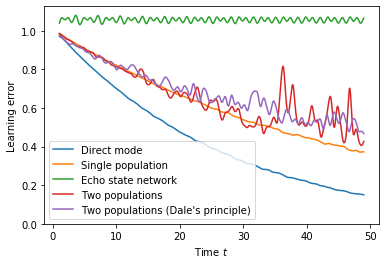

In [209]:
fig, ax = plt.subplots()
yss_arr = np.array(yss)
yss_mean = np.mean(yss_arr, axis=1)
yss_median = np.median(yss_arr, axis=1)
yss_stdd = np.sqrt(np.var(yss_arr, axis=1)) * 0.2
labels=[
    "Direct mode",
    "Single population",
    "Echo state network",
    "Two populations",
    "Two populations (Dale's principle)",
]
for i in range(yss_arr.shape[0]):
    if any(np.isnan(yss_median[i])):
        continue
    ax.plot(ts, yss_median[i], label=labels[i])
    ax.fill_between(ts, yss_mean[i] - yss_stdd[i], yss_mean[i] + yss_stdd[i], alpha=0.5)

ax.set_xlabel('Time $t$')
ax.set_ylabel('Learning error')
ax.set_ylim(0, None)
ax.legend()

In [44]:
#np.save('learnability_experiment_2020_01_25_18_27__.npz', yss_arr)

In [210]:
# Open in GUI
model, _, _ = build_test_network(
    n_golgi=200,
    n_granule=200,
    mode='two_populations'
)
nengo_gui.jupyter.InlineGUI(model)

error processing <Connection from <Ensemble "ens_pc"> to <Ensemble (unlabeled) at 0x7fcb38215d50>>
error processing <Connection from <Ensemble "ens_pc"> to <Ensemble (unlabeled) at 0x7fcb38215090>>
